In [1]:
import os
import sys
import glob
import torch
import pathlib
import numpy as np
from torch import nn
import albumentations
from torch.utils import data
import matplotlib.pyplot as plt
from typing import List, Callable, Tuple

from skimage.util import crop
from skimage.io import imread
from skimage.transform import resize
from sklearn.externals._pilutil import bytescale

from utils.data_utils import get_labels
from utils.transformations import (label_mapping, normalize_01, ComposeDouble, re_normalize, 
                                   FunctionWrapperDouble, cityscapes_label_to_rgb, AlbuSeg2d,
                                   multi_scale_aug, random_brightness)

from models.HRNet import HRNet


labels = get_labels()
trainid2label = { label.trainId : label for label in labels }

In [2]:
def get_filenames_of_path(path):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [pathlib.PurePath(file) for file in sorted(glob.glob(path))]
    return filenames


def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


class SegmentationDataset(data.Dataset):
    def __init__(self, config: dict, split="train", transform=None):
        self.config = config
        self.split = split
        
        search_image_files = os.path.join(
            config['cityscapes_dir'],
            config['trainval_image_dir'], 
            split, '*', 
            config['trainval_input_pattern'])

        search_annot_files = os.path.join(
            config['cityscapes_dir'],
            config['trainval_label_dir'], 
            split, '*', 
            config['trainval_annot_pattern'])
        
        
        # root directory
        root = pathlib.Path.cwd() 

        input_path = str(root / search_image_files)
        target_path = str(root / search_annot_files)
        
        self.inputs = get_filenames_of_path(search_image_files)
        self.targets = get_filenames_of_path(search_annot_files)
        
        print(self.inputs[5])
        print(self.targets[5])
        
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.int64

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index: int):
        # Select the sample
        input_ID = str(self.inputs[index])
        target_ID = str(self.targets[index])

        # Load input and target
        x, y = imread(input_ID), imread(target_ID)

        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)

        # Typecasting
        x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return x, y

In [3]:
config = {
    'cityscapes_dir': 'data/cityscapes',
    'trainval_input_pattern': '*_leftImg8bit.png',
    'trainval_annot_pattern': '*_gtFine_labelIds.png',
    'trainval_image_dir': 'leftImg8bit',
    'trainval_label_dir': 'gtFine',
}

ignore_label=-1
cityscapes_label_map = {-1: ignore_label,   0: ignore_label,   1: ignore_label, 
                         2: ignore_label,   3: ignore_label,   4: ignore_label, 
                         5: ignore_label,   6: ignore_label,   7: 0, 
                         8:  1,             9: ignore_label,  10: ignore_label, 
                         11: 2,            12: 3,             13: 4, 
                         14: ignore_label, 15: ignore_label,  16: ignore_label, 
                         17: 5,            18: ignore_label,  19: 6,  
                         20: 7,            21: 8,             22: 9, 
                         23: 10,           24: 11,            25: 12, 
                         26: 13,           27: 14,            28: 15, 
                         29: ignore_label, 30: ignore_label,  31: 16, 
                         32: 17,           33: 18}

In [4]:
# training transformations and augmentations
transforms_training = ComposeDouble([
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(multi_scale_aug, scale_factor=8, crop_size=(512, 1024), base_size=2048, 
                          ignore_label=ignore_label, both=True),
    FunctionWrapperDouble(label_mapping, label_map=cityscapes_label_map, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01, input=True, target=False)
])


# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(multi_scale_aug, valid=True, crop_size=(512, 1024), both=True),
    FunctionWrapperDouble(label_mapping, label_map=cityscapes_label_map, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01, input=True, target=False)
])



    # FunctionWrapperDouble(resize, input=True, target=False, output_shape=(512, 1024, 3)),
    # FunctionWrapperDouble(resize, input=False, target=True, output_shape=(512, 1024), order=0, 
                          # anti_aliasing=False, preserve_range=True),

In [5]:
train_dataset = SegmentationDataset(config=config, split="train", transform=transforms_training)

train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=12, shuffle=True)

valid_dataset = SegmentationDataset(config=config, split="val", transform=transforms_validation)

valid_dataloader = data.DataLoader(dataset=valid_dataset, batch_size=12, shuffle=True)

data/cityscapes/leftImg8bit/train/aachen/aachen_000005_000019_leftImg8bit.png
data/cityscapes/gtFine/train/aachen/aachen_000005_000019_gtFine_labelIds.png
data/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_002196_leftImg8bit.png
data/cityscapes/gtFine/val/frankfurt/frankfurt_000000_002196_gtFine_labelIds.png


In [6]:
x, y = next(iter(train_dataloader))
xv, yv = next(iter(valid_dataloader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; type: {y.dtype}')
print(f'class: {y.unique()}')

(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
(1024, 2048, 3)
x = shape: torch.Size([12, 3, 512, 1024]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([12, 512, 1024, 1]); type: torch.int64
class: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,
         15,  16,  17,  18, 255])


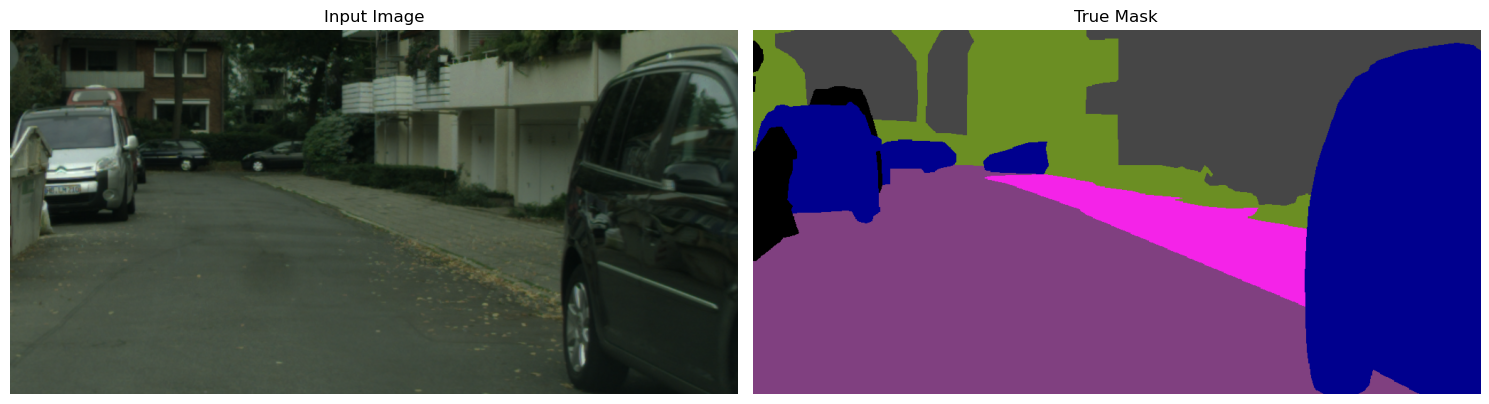

In [7]:
display([x[0].permute(1,2,0), cityscapes_label_to_rgb(y[0])])

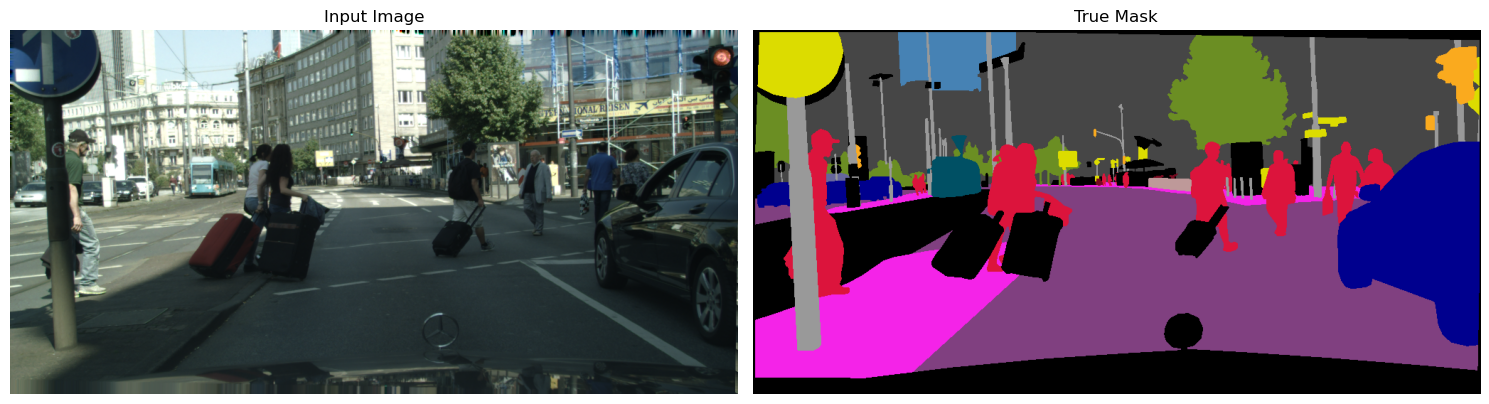

In [8]:
display([xv[0].permute(1,2,0), cityscapes_label_to_rgb(yv[0])])

In [ ]:
from utils.visual import DatasetViewer
dataset_viewer_training = DatasetViewer(train_dataset) 
dataset_viewer_training.napari()

In [ ]:
model = HRNet(
    stage1_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 1,'BLOCK': 'BOTTLENECK','NUM_BLOCKS': [4]}, 
    stage2_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 2,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4]},
    stage3_cfg = {'NUM_MODULES': 4,'NUM_BRANCHES': 3,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4]},
    stage4_cfg = {'NUM_MODULES': 3,'NUM_BRANCHES': 4,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4, 4]},
    input_height = 512, 
    input_width = 1024, 
    n_classes = 19, 
    W = 40,
)

In [ ]:
x = torch.randn(size=(1, 3, 512, 1024), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

In [ ]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None \
                and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    # learning rate scheduler step with validation loss
                    self.lr_scheduler.batch(self.validation_loss[i])  
                else:
                    # learning rate scheduler step
                    self.lr_scheduler.batch()  
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', 
                          total=len(self.training_DataLoader), leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', 
                          total=len(self.validation_DataLoader), leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

In [ ]:
# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=2,
                  epoch=0,
                  notebook=True)

# start training
# training_losses, validation_losses, lr_rates = trainer.run_trainer()